### 5. juli

Venter på å få tilgang på super-computers ved Fysisk institutt. I mens prøver jeg å undersøke litt selv. Ønsker å lære mer om t-SNE (T-Distributed Stochastic Neighbor Embedding) visualisering av MNIST-datasettet. Leste artikkelen https://towardsdatascience.com/dimensionality-reduction-using-t-distributed-stochastic-neighbor-embedding-t-sne-on-the-mnist-9d36a3dd4521 og ved å bruke min tidligere nettverk-kode fikk jeg til å visualisere hvordan dataen grupperer seg. Leste også litt mer om hva som faktisk skjer i t-SNE.

Plottet også vektendring over tid for layer 2 som kan sees helt i bunnen av 01-04_07_23 ipynb.

Snakket med de to andre studentene som jobber med Chialvo-Bak-modellen. Fikk vite at vi skal sammenligne vektendringer i feed-forward-modellen som jeg jobber med og Chialvo-Bak-modellen som de jobber med.

Fikk tilgang til tungregningsmaskinene på insituttet og fikk logget meg inn. Prøvde å koble meg til JupyterHub, men det viste seg å være komplisert.

Fant ut av hvordan jeg kan få sannsynlighetstettheten til å ligge ved bin-høyde, men er ikke sikker på om dette da gir riktig implementasjon av sannsynlighetstetheten, da denne skal være definert som 
$$f(\Delta w) = \frac{n}{\delta N_{tot}}$$
hvor $\Delta w$ er vektendringen, $n$ er antall counts i en spesifikk bin, $N_{tot}$ er totalt antall counts og $\delta$ er bin-bredden til samme spesifikke bin.

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange

In [51]:
# Hyperparameters
input_dim = 28**2  # MNIST images are 28x28 pixels
hidden_dim1 = 128  # Number of units in the first hidden layer
hidden_dim2 = 100  # Number of units in the second hidden layer
learning_rate = 0.01
output_dim = 10  # Initial output classes 
batch_size = 64
num_epochs = 10

# Set random seed for reproducibility
torch.manual_seed(42)

In [52]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)
        self.R = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.R(self.layer1(x))
        x = self.R(self.layer2(x))
        x = self.layer3(x)
        return x

In [53]:
# Normalizes the data like I did earlier by dividing by 255.0
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [54]:
# Create an instance of the network
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [42]:
# Extract feature embeddings and labels from the train dataset before training
embeddings_train_before = []
labels_train_before = []

for images, targets in train_loader:
    # Forward pass through the model
    outputs = model(images)
    
    # Get the feature embeddings
    embeddings_train_before.append(outputs.detach().numpy())
    
    # Get the labels
    labels_train_before.append(targets.numpy())

# Concatenate the lists into numpy arrays
embeddings_train_before = np.concatenate(embeddings_train_before, axis=0)
labels_train_before = np.concatenate(labels_train_before, axis=0)

# Perform t-SNE dimensionality reduction for train data before training
tsne_train_before = TSNE(n_components=2, random_state=42)
embeddings_train_before_tsne = tsne_train_before.fit_transform(embeddings_train_before)

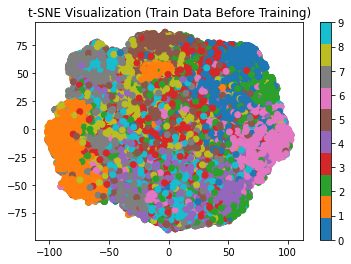

In [43]:
# Create a scatter plot of the t-SNE embeddings with labels for train data before training
plt.scatter(embeddings_train_before_tsne[:, 0], embeddings_train_before_tsne[:, 1], c=labels_train_before, cmap='tab10')
plt.colorbar()
plt.title('t-SNE Visualization (Train Data Before Training)')
plt.show()

In [44]:
# Training loop
for epoch in trange(num_epochs):
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

 10%|█         | 1/10 [00:19<02:54, 19.40s/it]

Epoch [1/10], Loss: 0.6073


 20%|██        | 2/10 [00:39<02:37, 19.69s/it]

Epoch [2/10], Loss: 0.2122


 30%|███       | 3/10 [00:58<02:17, 19.58s/it]

Epoch [3/10], Loss: 0.2461


 40%|████      | 4/10 [01:18<01:58, 19.83s/it]

Epoch [4/10], Loss: 0.2856


 50%|█████     | 5/10 [01:39<01:39, 19.96s/it]

Epoch [5/10], Loss: 0.3651


 60%|██████    | 6/10 [02:00<01:21, 20.46s/it]

Epoch [6/10], Loss: 0.1006


 70%|███████   | 7/10 [02:29<01:10, 23.38s/it]

Epoch [7/10], Loss: 0.3040


 80%|████████  | 8/10 [02:53<00:47, 23.56s/it]

Epoch [8/10], Loss: 0.4737


 90%|█████████ | 9/10 [03:14<00:22, 22.52s/it]

Epoch [9/10], Loss: 0.0660


100%|██████████| 10/10 [03:37<00:00, 21.75s/it]

Epoch [10/10], Loss: 0.4055


In [45]:
# Extract feature embeddings and labels from the train dataset after training
embeddings_train_after = []
labels_train_after = []

for images, targets in train_loader:
    # Forward pass through the model
    outputs = model(images)
    
    # Get the feature embeddings
    embeddings_train_after.append(outputs.detach().numpy())
    
    # Get the labels
    labels_train_after.append(targets.numpy())

# Concatenate the lists into numpy arrays
embeddings_train_after = np.concatenate(embeddings_train_after, axis=0)
labels_train_after = np.concatenate(labels_train_after, axis=0)

# Perform t-SNE dimensionality reduction for train data after training
tsne_train_after = TSNE(n_components=2, random_state=42)
embeddings_train_after_tsne = tsne_train_after.fit_transform(embeddings_train_after)


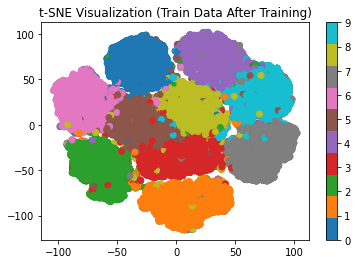

In [46]:
# Create a scatter plot of the t-SNE embeddings with labels for train data after training
plt.scatter(embeddings_train_after_tsne[:, 0], embeddings_train_after_tsne[:, 1], c=labels_train_after, cmap='tab10')
plt.colorbar()
plt.title('t-SNE Visualization (Train Data After Training)')
plt.show()


In [47]:
# Extract feature embeddings and labels from the test dataset after training
embeddings_test = []
labels_test = []

for images, targets in test_loader:
    # Forward pass through the model
    outputs = model(images)
    
    # Get the feature embeddings
    embeddings_test.append(outputs.detach().numpy())
    
    # Get the labels
    labels_test.append(targets.numpy())

# Concatenate the lists into numpy arrays
embeddings_test = np.concatenate(embeddings_test, axis=0)
labels_test = np.concatenate(labels_test, axis=0)

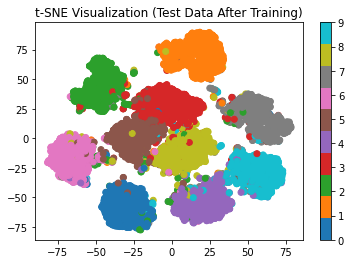

In [48]:
# Perform t-SNE dimensionality reduction for test data after training
tsne_test = TSNE(n_components=2, random_state=42)
embeddings_test_tsne = tsne_test.fit_transform(embeddings_test)

# Create a scatter plot of the t-SNE embeddings with labels for test data after training
plt.scatter(embeddings_test_tsne[:, 0], embeddings_test_tsne[:, 1], c=labels_test, cmap='tab10')
plt.colorbar()
plt.title('t-SNE Visualization (Test Data After Training)')
plt.show()